# Test xgb code

In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
from preprocess import loadPreData
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.cross_validation import KFold
subm_folder = './submissions'

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data = loadPreData()

Index([u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'NumMosquitos', u'WnvPresent'],
      dtype='object')
Index([u'Id', u'Address', u'Species', u'Block', u'Street', u'Trap',
       u'AddressNumberAndStreet', u'Latitude', u'Longitude',
       u'AddressAccuracy'],
      dtype='object')


In [3]:
data['train'].columns

Index([u'Species', u'Block', u'Street', u'Trap', u'Latitude', u'Longitude',
       u'AddressAccuracy', u'month', u'day', u'Lat_int', u'Long_int',
       u'Tmax_x', u'Tmin_x', u'Tavg_x', u'Depart_x', u'DewPoint_x',
       u'WetBulb_x', u'Heat_x', u'Cool_x', u'Sunrise_x', u'Sunset_x',
       u'Depth_x', u'SnowFall_x', u'PrecipTotal_x', u'StnPressure_x',
       u'SeaLevel_x', u'ResultSpeed_x', u'ResultDir_x', u'AvgSpeed_x',
       u'Tmax_y', u'Tmin_y', u'Tavg_y', u'DewPoint_y', u'WetBulb_y', u'Heat_y',
       u'Cool_y', u'PrecipTotal_y', u'StnPressure_y', u'SeaLevel_y',
       u'ResultSpeed_y', u'ResultDir_y', u'AvgSpeed_y', u'DateCount'],
      dtype='object')

In [4]:
X = data['train'].get_values().astype(float)
Y = data['labels']

### Split data into train and validation set

In [5]:
# split data into train and test sets
seed = 7
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)

### Train model

In [6]:
# fit model 
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [7]:
preds = model.predict(X_test)

### Get accuracy on validation data

In [8]:
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 94.20%


## Plot AUC

In [9]:
def scoreAUC(y,probs):
    ps = np.linspace(0.,1.,num=100)
    prs = []
    nrs = []
    for p in ps:
        preds = probs[:,0]<p
        pr = np.sum((y & preds))/float(np.sum(y))
        nr = np.sum((1-y & 1-preds))/float(np.sum(1-y))
        nrs.append(nr)
        prs.append(pr)
    xs = 1-np.array(nrs)
    ys = np.array(prs)
    dxs = xs[1:] - xs[:-1]
    ays = .5*(ys[1:] + ys[:-1])
    auc = np.sum(ays*dxs)
    return {'score':auc,'fpr':xs,'tpr':ys}

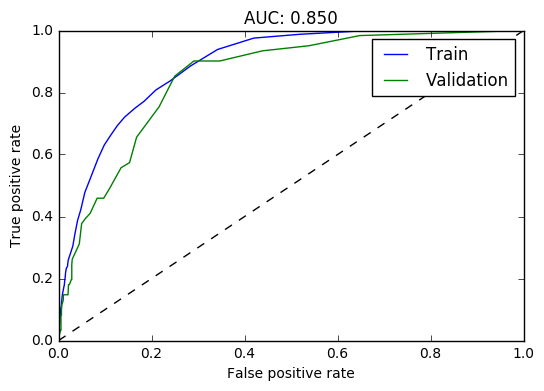

In [15]:
probs = model.predict_proba(X_train)
auc = scoreAUC(y_train,probs)
plt.plot(auc['fpr'],auc['tpr'],label='Train');

probs = model.predict_proba(X_test)
auc = scoreAUC(y_test,probs)
plt.plot(auc['fpr'],auc['tpr'],label='Validation');

plt.legend();

plt.plot([0,1.],[0,1.],'k--');
plt.xlabel('False positive rate');
plt.ylabel('True positive rate');


plt.title('AUC: {:.3f}'.format(auc['score']));

In [11]:
X_sub = data['test'].get_values()

In [12]:
probs = model.predict_proba(X_sub)

In [13]:
#prepare submission
ss = pd.DataFrame(columns=['Id','WnvPresent'])
ss['WnvPresent'] = pd.Series(probs[:,1])
ss['Id'] = data['test'].index + 1
ss.to_csv(os.path.join(subm_folder, 'xgb_submission.csv'), index=False)

Produces score of 0.76064 so around 390th place

## xgb using Kfolds

In [109]:
X = data['train'].get_values().astype(float)
Y = data['labels']

In [112]:
nb_folds = 4
kfolds = KFold(len(Y), nb_folds)

In [133]:
av_roc = 0.
f = 0

fold_probs = []
aucs = []
for train, valid in kfolds:
    print('---'*20)
    print('Fold', f)
    print('---'*20)
    f += 1
    X_train = X[train]
    X_valid = X[valid]
    Y_train = Y[train]
    Y_valid = Y[valid]


    print("Building model...")
    model = XGBClassifier()

    print("Training model...")
    
    model.fit(X_train, Y_train)
    probs = model.predict_proba(X_valid)
    auc = scoreAUC(Y_valid,probs)
    print 'AUC : {}'.format(auc['score'])
    
    fold_prob = model.predict_proba(X_sub)
    fold_probs.append(fold_prob)
    aucs.append(auc['score'])

------------------------------------------------------------
('Fold', 0)
------------------------------------------------------------
Building model...
Training model...
AUC : 0.76204927286
------------------------------------------------------------
('Fold', 1)
------------------------------------------------------------
Building model...
Training model...
AUC : 0.771135467022
------------------------------------------------------------
('Fold', 2)
------------------------------------------------------------
Building model...
Training model...
AUC : 0.785425368628
------------------------------------------------------------
('Fold', 3)
------------------------------------------------------------
Building model...
Training model...
AUC : 0.758053494398


In [141]:
aucs = np.array(aucs)
aucs = aucs/np.sum(aucs)
fold_probs = np.array(fold_probs)

In [142]:
fprobs = fold_probs[:,:,1]

In [144]:
subs = np.sum((np.tile(aucs,(fprobs.shape[1],1)).T)*fprobs,axis=0)

In [145]:
subs.shape

(116293,)

In [146]:
#prepare submission
ss = pd.DataFrame(columns=['Id','WnvPresent'])
ss['WnvPresent'] = pd.Series(subs)
ss['Id'] = data['test'].index + 1
ss.to_csv(os.path.join(subm_folder, 'xgb_kfold_submission.csv'), index=False)

Score of 0.75533 so slightly worse